**The goal is to check the distribution of both the original data and the syntheic data to see if there is any difference**

In [2]:
import os
import sys
import joblib
import warnings
import sdmetrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler
from sdmetrics.visualization import get_column_plot
from sdmetrics.reports.single_table import QualityReport
warnings.filterwarnings('ignore')
sys.path.append( '../util' )
import util as util

**1. Load the datasets**

In [3]:
DATASET_DIRECTORY = '../csvfiles/'

dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [4]:
file_names = []
for file in os.listdir(DATASET_DIRECTORY):
        file_names.append(file)
    
original_dataset = util.read_dataset(file_names, None)

In [5]:
original_df = pd.DataFrame(original_dataset)
original_df['label'] = original_df['label'].map(dict_7classes).astype('category')
original_df['label'].value_counts()

label
DDoS          33984560
DoS            8090738
Mirai          2634124
Benign         1098195
Spoofing        486504
Recon           354565
Web              24829
BruteForce       13064
Name: count, dtype: int64

In [6]:
original_df.shape

(46686579, 47)

**1.1 Generate load synthetic data**

In [6]:
ctgan_model = CTGAN.load('../generator_custom/medium_synthesizer.pkl')

In [7]:
synthetic_data = ctgan_model.sample(4000000)

In [8]:
discrete_columns = [util.y_column, 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 
                    'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']

encoders = {}
encoders_new = joblib.load('column_encoders.joblib')

for column in discrete_columns:
    if column in encoders_new:
        synthetic_data[column] = encoders_new[column].inverse_transform(synthetic_data[column])

In [9]:
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df['label'].value_counts()

label
DDoS          2478903
DoS            598923
Mirai          247685
Benign         207736
Recon          189972
Spoofing       143952
BruteForce     102627
Web             30202
Name: count, dtype: int64

In [10]:
synthetic_df.shape

(4000000, 47)

**2. Create a sample of equal amount from the original**

In [11]:
original_sample = original_df.sample(n = 4000000, replace = False, ignore_index = True)

In [12]:
original_sample.shape, synthetic_df.shape

((4000000, 47), (4000000, 47))

**3. Lets see if there is a discrepancy between the label counts**

In [13]:
original_sample['label'].value_counts()

label
DDoS          2911716
DoS            693258
Mirai          225280
Benign          94492
Spoofing        41679
Recon           30338
Web              2135
BruteForce       1102
Name: count, dtype: int64

In [14]:
synthetic_df['label'].value_counts()

label
DDoS          2478903
DoS            598923
Mirai          247685
Benign         207736
Recon          189972
Spoofing       143952
BruteForce     102627
Web             30202
Name: count, dtype: int64

In [15]:
original_data_labels = [x for x in original_sample['label']]
synthetic_data_labels = [x for x in synthetic_df['label']]
combined_labels = original_data_labels + synthetic_data_labels

combined_df = pd.DataFrame(combined_labels, columns = ['label'])

combined_df.loc[:len(combined_df) // 2, 'data_source'] = 'Original Data'
combined_df.loc[(len(combined_df) // 2) - 1:, 'data_source'] = 'Synthetic Data'
combined_df = combined_df.iloc[:-1]

combined_df


,label,data_source
0,DoS,Original Data
1,DDoS,Original Data
2,DDoS,Original Data
3,DDoS,Original Data
4,DDoS,Original Data
...,...,...
7999994,DDoS,Synthetic Data
7999995,DoS,Synthetic Data
7999996,DDoS,Synthetic Data
7999997,DDoS,Synthetic Data


This is a layered graph. This will show the difference in label count between the 8 labels for the 2 data sources

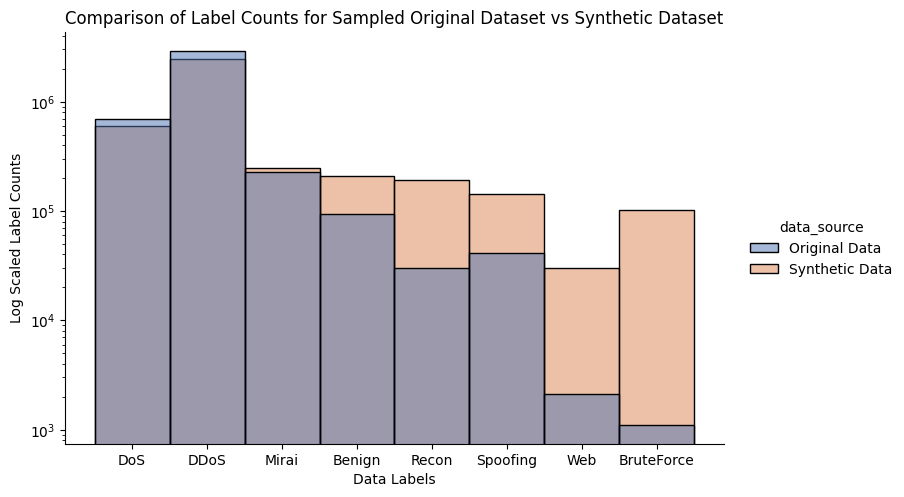

In [25]:
sns.displot(data = combined_df.sort_values(by = ['data_source']), x = 'label', hue = 'data_source', aspect = 1.5, multiple = 'layer', palette = 'deep')

plt.yscale('log')
plt.xlabel(xlabel = 'Data Labels')
plt.ylabel(ylabel = 'Log Scaled Label Counts')
plt.title(label = 'Comparison of Label Counts for Sampled Original Dataset vs Synthetic Dataset')

plt.savefig('layered_label_count')

In [19]:
del combined_df, synthetic_data_labels, original_data_labels

In [37]:
synthetic_df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

In [52]:
synthetic_df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,-0.020548,-0.099074,0.887062,-0.167973,0.057174,0.072034,-0.000842,-0.308079,-0.511166,-0.315431,...,-0.207489,-0.314580,-0.010631,0.001098,-0.345600,-0.208059,-0.094124,-0.413261,0.001167,DoS
1,-0.006266,-0.166075,-0.343389,-0.167610,-0.091072,-0.090670,-0.000755,-0.307828,1.956385,-0.315541,...,-0.207478,-0.289093,4.897042,4.882892,-0.303292,-0.207214,-0.094228,-0.413730,4.891167,Benign
2,-0.020176,-0.165964,-0.902363,-0.166647,-0.091270,-0.091011,-0.000743,-0.307712,-0.511201,-0.315435,...,-0.207221,-0.348968,-0.002940,0.001294,-0.475610,-0.207721,-0.093951,-0.413468,0.001137,DDoS
3,-0.020863,-0.165970,-0.343208,-0.167221,-0.090805,-0.090751,-0.000686,-0.308050,-0.511178,-0.315527,...,-0.207288,-0.283130,0.007793,0.001495,-0.331666,-0.207976,-0.094116,-0.413646,0.001156,DDoS
4,-0.020576,-0.166892,-0.902768,-0.168090,-0.090704,-0.090905,-0.000815,-0.307638,-0.511317,-0.315600,...,-0.208621,-0.339476,-0.003148,0.001254,-0.477389,-0.208222,-0.094689,-0.413905,0.001260,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.020257,-0.166433,-0.342966,-0.167801,-0.090169,-0.090358,-0.000866,-0.307993,1.956526,-0.315413,...,-0.207569,-0.297248,-0.006891,0.001263,-0.295301,-0.207821,-0.093707,-0.413864,0.000929,DDoS
3999996,-0.019251,-0.164556,0.885727,-0.167754,-0.090650,-0.090826,-0.000697,-0.307813,-0.511382,-0.315518,...,-0.208101,0.069068,-0.004438,0.001361,0.613336,-0.207649,-0.093934,-0.414638,0.001220,DoS
3999997,-0.020298,-0.165967,-0.342756,-0.168661,-0.089540,-0.089559,-0.000781,-0.307703,1.956263,-0.315360,...,-0.207341,-0.296746,-0.005968,0.001513,-0.293793,-0.207246,-0.093329,-0.413330,0.000886,DDoS
3999998,0.005643,-0.131456,-0.100458,4.015462,-0.091043,-0.090618,-0.000790,-0.307799,-0.511132,-0.315720,...,0.685973,0.004314,4.914316,4.884849,-0.066526,0.668895,-0.095027,3.881294,4.894707,Web


In [50]:
data_fig = get_column_plot(
    real_data = original_sample,
    synthetic_data = synthetic_df,
    column_name = 'label'
)

In [51]:
data_fig.write_html('plot.html')

**4. Get metadata from data**
This section will be dealing with this API: https://docs.sdv.dev/sdmetrics/reports/quality-report/single-table-api

In [126]:
metadata_orig_sample = original_sample
metadata_orig_sample['pk'] = range(0, len(original_sample))
metadata_orig_sample.set_index('pk')

metadata_syn_sample = synthetic_df
metadata_syn_sample['pk'] = range(0, len(original_sample))
metadata_syn_sample.set_index('pk')

original_sample

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,pk
0,-0.019346,-0.166105,-0.342706,-0.167679,-0.091005,-0.091005,-0.000754,-0.307859,1.955276,-0.315454,...,-0.292659,0.010742,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,0
1,-0.020227,-0.166154,-0.342706,-0.167679,-0.091016,-0.091016,-0.000754,3.248241,-0.511437,3.170039,...,-0.292659,0.009458,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,1
2,-0.020227,-0.166271,4.188047,-0.213330,-0.091024,-0.091024,-0.000754,-0.307859,-0.511437,-0.315454,...,1.855225,0.027229,0.001844,2.413413,-0.162372,-0.092191,-0.156384,0.001786,Mirai,2
3,-0.020227,-0.166271,-0.901644,-0.167679,-0.085243,-0.085243,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.342338,-0.003382,0.001844,-0.458554,-0.207678,-0.094913,-0.413893,0.001786,DDoS,3
4,-0.020227,-0.166154,-0.342706,-0.167679,-0.083544,-0.083544,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,-0.013576,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DoS,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.003686,-0.166037,-0.342706,-0.167679,-0.091035,-0.091035,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,-0.013549,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DoS,3999995
3999996,-0.020227,-0.166154,-0.342706,-0.167679,-0.090888,-0.090888,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,-0.006237,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,3999996
3999997,-0.020227,-0.166154,-0.342706,-0.031436,-0.090989,-0.090989,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,0.007752,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,3999997
3999998,-0.020221,-0.166149,-0.330410,-0.167679,-0.090922,-0.090922,-0.000754,-0.307859,1.955276,-0.315454,...,-0.291790,-0.005465,0.001844,-0.314772,-0.204416,-0.094905,0.015289,0.001786,DDoS,3999998


Setup the metadata for the report

In [102]:
metadata = {
    'primary_key': 'pk',
    'columns': {column: {'sdtype': 'numerical', "compute_representation": "Float"} for column in original_sample.columns}
}

metadata['columns']['label']['sdtype'] = 'categorical'
metadata['columns']['pk']['sdtype'] = 'id'

metadata

{'primary_key': 'pk',
 'columns': {'flow_duration': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'Header_Length': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Protocol Type': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Duration': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Rate': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Srate': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Drate': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'fin_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'syn_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'rst_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'psh_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'ack_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'ece_flag_number': 

Start quality report

In [127]:
report = QualityReport()

report.generate(
    real_data = metadata_orig_sample,
    synthetic_data = metadata_syn_sample,
    metadata = metadata,
    verbose = True 
)

Generating report ...



(1/2) Evaluating Column Shapes: |██████████| 48/48 [00:52<00:00,  1.10s/it]|
Column Shapes Score: 65.92%

(2/2) Evaluating Column Pair Trends: |██████████| 1128/1128 [16:58<00:00,  1.11it/s]|
Column Pair Trends Score: 94.72%

Overall Score (Average): 80.32%



In [128]:
report.get_score()

0.8031928877238592

In [129]:
report.get_details('Column Shapes')

,Column,Metric,Score
0,flow_duration,KSComplement,0.617217
1,Header_Length,KSComplement,0.658847
2,Protocol Type,KSComplement,0.738596
3,Duration,KSComplement,0.613582
4,Rate,KSComplement,0.751183
5,Srate,KSComplement,0.764605
6,Drate,KSComplement,0.235067
7,fin_flag_number,KSComplement,0.470925
8,syn_flag_number,KSComplement,0.232752
9,rst_flag_number,KSComplement,0.501954


In [107]:
fig = report.get_visualization('Column Shapes')
fig.write_html('column_shapes.html')

In [123]:
fig = report.get_visualization('Column Pair Trends')

# Need larger size to show all of the features in the data
fig.update_layout(width = 6000, height = 6000)
fig.update_xaxes(tickangle = 90)

fig.update_layout(
    xaxis = dict(
        tickfont = dict(
            size = 30
        )
    ),
    yaxis = dict(
        tickfont = dict(
            size = 30
        )
    )
)

fig.write_html('column_pair_trends.html')

In [140]:
del fig, metadata_syn_sample, metadata_orig_sample, metadata

**5. Compare simple stats between Synthetic and Original Datasets**

In [13]:
# This is for if you are running the cells in order
try:
    original_sample = original_sample.drop(['pk'], axis = 1)
    synthetic_df = synthetic_df.drop(['pk'], axis = 1)
except:
    original_sample.shape, synthetic_df.shape

In [42]:
describe_original = original_sample.describe()
describe_synthetic = synthetic_df.describe()

In [47]:
describe_synthetic.T

,count,mean,std,min,25%,50%,75%,max
flow_duration,4000000.0,0.002993,0.070732,-0.144689,-0.020516,-0.019969,-0.018912,0.454646
Header_Length,4000000.0,0.053376,0.916115,-0.899903,-0.166230,-0.165707,-0.118436,9.100366
Protocol Type,4000000.0,-0.006788,0.965711,-1.239637,-0.343415,-0.342623,0.585299,4.277723
Duration,4000000.0,-0.046736,0.964131,-4.239241,-0.168176,-0.167565,-0.162749,6.666350
Rate,4000000.0,-0.034777,0.267536,-0.485042,-0.090996,-0.090473,-0.089701,3.579874
Srate,4000000.0,-0.032579,0.277429,-0.139421,-0.091006,-0.090524,-0.089749,3.905062
Drate,4000000.0,-0.000663,0.000147,-0.002269,-0.000747,-0.000659,-0.000572,0.000329
fin_flag_number,4000000.0,-0.058478,0.908089,-0.308514,-0.307906,-0.307821,-0.307722,3.249912
syn_flag_number,4000000.0,-0.099182,0.920237,-0.512029,-0.511249,-0.511147,-0.511009,1.956986
rst_flag_number,4000000.0,-0.056406,0.914320,-0.316433,-0.315513,-0.315424,-0.315328,3.172413


array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>, <Axes: title={'center': 'min'}>],
       [<Axes: title={'center': '25%'}>, <Axes: title={'center': '50%'}>,
        <Axes: title={'center': '75%'}>],
       [<Axes: title={'center': 'max'}>, <Axes: >, <Axes: >]],
      dtype=object)

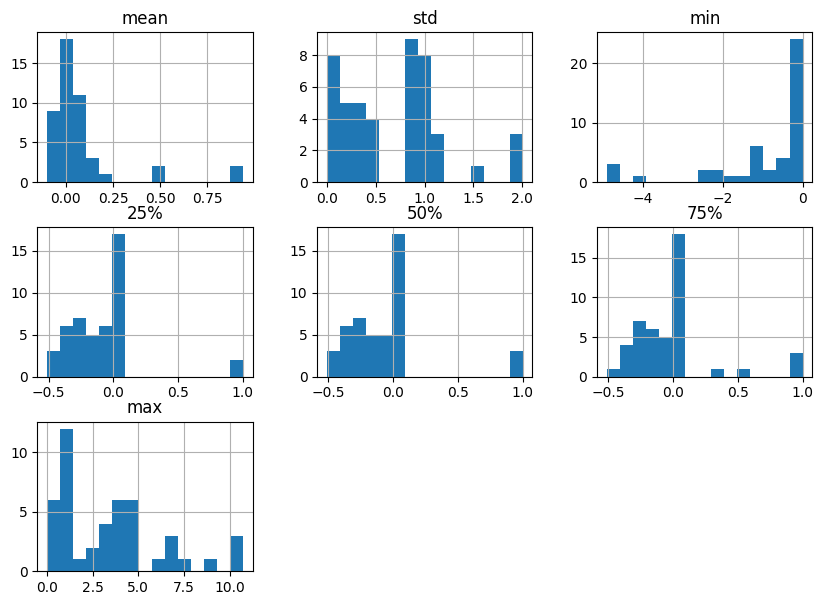

In [44]:
mean_synthetic.T.hist(
    column = [x for x in list(describe_synthetic.T.columns) if x != 'count'],
    figsize = (10, 7),
    bins = 15
)

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>, <Axes: title={'center': 'min'}>],
       [<Axes: title={'center': '25%'}>, <Axes: title={'center': '50%'}>,
        <Axes: title={'center': '75%'}>],
       [<Axes: title={'center': 'max'}>, <Axes: >, <Axes: >]],
      dtype=object)

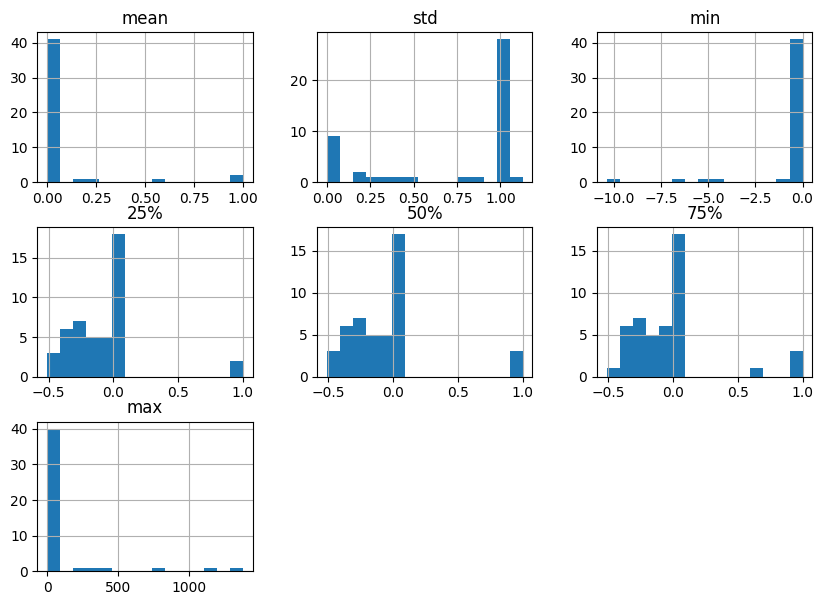

In [45]:
mean_original.T.hist(
    column = [x for x in list(describe_original.T.columns) if x != 'count'],
    figsize = (10, 7),
    bins = 15
)

In [74]:
describe_original.T

,count,mean,std,min,25%,50%,75%,max
flow_duration,4000000.0,-2.545865e-04,1.129086,-0.020227,-0.020227,-0.020227,-0.019859,1383.523438
Header_Length,4000000.0,-5.802028e-04,0.997085,-0.166271,-0.166154,-0.166154,-0.165679,21.304956
Protocol Type,4000000.0,5.901509e-04,1.000532,-1.013432,-0.342706,-0.342706,0.600781,4.240587
Duration,4000000.0,-9.340724e-04,0.996280,-4.732850,-0.167679,-0.167679,-0.167679,13.456505
Rate,4000000.0,3.411444e-05,0.999988,-0.091039,-0.091018,-0.090881,-0.089862,84.163666
Srate,4000000.0,3.411444e-05,0.999988,-0.091039,-0.091018,-0.090881,-0.089862,84.163666
Drate,4000000.0,-3.417844e-04,0.192966,-0.000754,-0.000754,-0.000754,-0.000754,301.000183
fin_flag_number,4000000.0,-3.807707e-04,0.999440,-0.307859,-0.307859,-0.307859,-0.307859,3.248241
syn_flag_number,4000000.0,2.767637e-05,1.000020,-0.511437,-0.511437,-0.511437,-0.511437,1.955276
rst_flag_number,4000000.0,-4.434516e-04,0.999367,-0.315454,-0.315454,-0.315454,-0.315454,3.170039


In [71]:
data_diff = np.abs(describe_original.T - describe_synthetic.T)
data_diff

,count,mean,std,min,25%,50%,75%,max
flow_duration,0.0,3.247689e-03,1.058354,0.124461,0.000289,0.000258,0.000948,1383.068792
Header_Length,0.0,5.395607e-02,0.080970,0.733632,0.000077,0.000447,0.047243,12.204591
Protocol Type,0.0,7.377944e-03,0.034821,0.226205,0.000709,0.000083,0.015482,0.037136
Duration,0.0,4.580194e-02,0.032149,0.493609,0.000497,0.000114,0.004929,6.790155
Rate,0.0,3.481125e-02,0.732452,0.394003,0.000022,0.000408,0.000161,80.583791
Srate,0.0,3.261340e-02,0.722560,0.048382,0.000012,0.000356,0.000113,80.258604
Drate,0.0,3.215574e-04,0.192818,0.001516,0.000007,0.000095,0.000182,300.999854
fin_flag_number,0.0,5.809709e-02,0.091351,0.000655,0.000047,0.000038,0.000137,0.001671
syn_flag_number,0.0,9.920966e-02,0.079783,0.000592,0.000187,0.000290,0.000428,0.001710
rst_flag_number,0.0,5.596247e-02,0.085047,0.000979,0.000060,0.000030,0.000125,0.002374


In [68]:
scaler = MinMaxScaler()
data_diff_scaled = scaler.fit_transform(data_diff)

In [69]:
data_diff_df = pd.DataFrame(data_diff_scaled, index = data_diff.index, columns = data_diff.columns)
data_diff_df = data_diff_df.drop('count', axis = 1)

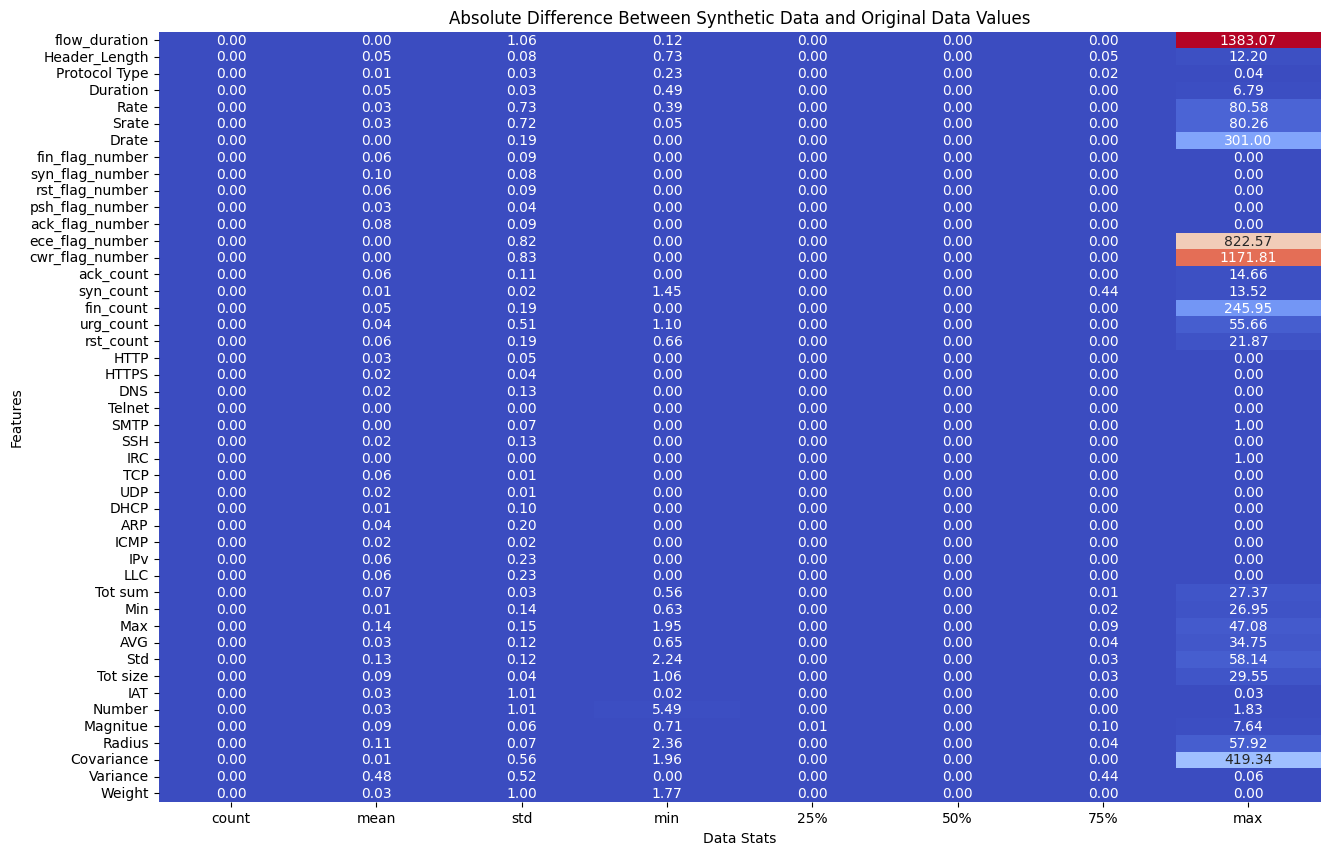

In [75]:
plt.figure(figsize=(15, 10))

sns.heatmap(data_diff, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)

plt.xlabel('Data Stats')
plt.ylabel('Features')
plt.title('Absolute Difference Between Synthetic Data and Original Data Values')

plt.show()

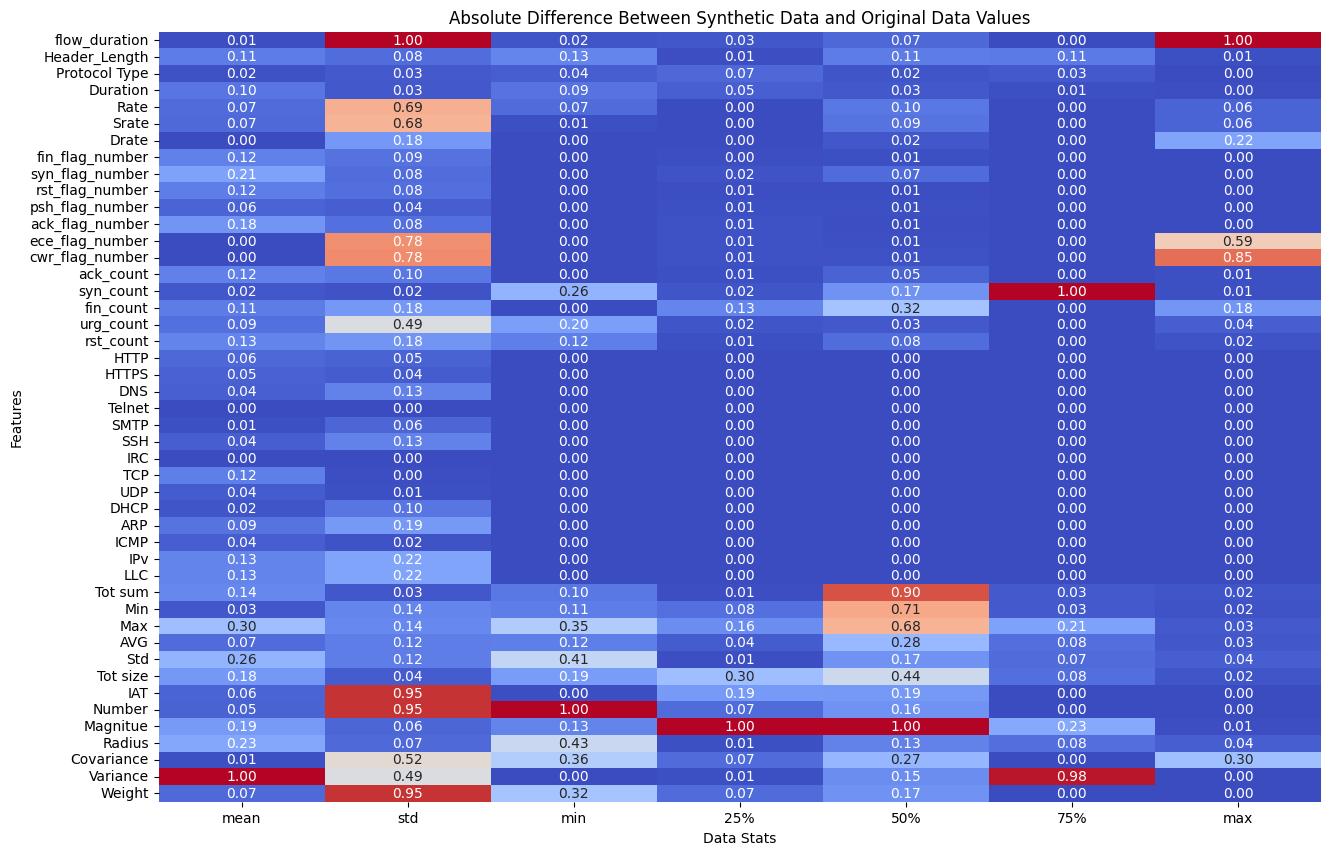

In [76]:
plt.figure(figsize=(15, 10))

sns.heatmap(data_diff_df, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)

plt.xlabel('Data Stats')
plt.ylabel('Features')
plt.title('Absolute Difference Between Synthetic Data and Original Data Values')

plt.show()